In [1]:
%load_ext autoreload
%autoreload 2

import os

print("original dir: ", os.getcwd())

if os.getcwd().endswith("3.0A"):
    new_path = "../"
    os.chdir(new_path)
    print("changed dir: ", os.getcwd())

original dir:  e:\SUSTech-Battery\data_our_refined\3.0A
changed dir:  e:\SUSTech-Battery\data_our_refined


In [2]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial
import matplotlib.pyplot as plt
import seaborn as sns

from utils import read_capacity_data

plt.style.use(style="seaborn-v0_8-talk")
sns.set_theme(style="darkgrid")

In [26]:
true_capacity4, pred_capacity4 = read_capacity_data("./3.0A/4")
true_capacity5, pred_capacity5 = read_capacity_data("./3.0A/5")
true_capacity6, pred_capacity6 = read_capacity_data("./3.0A/6")

True capacity shape: (679,)
Pred capacity shape: (679, 1)
--------------------------------------------------
True capacity shape: (689,)
Pred capacity shape: (689, 1)
--------------------------------------------------
True capacity shape: (920,)
Pred capacity shape: (920, 1)
--------------------------------------------------


In [36]:
THRESHOLD = 0.80

In [6]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

def poly_fit(x, y, order):
    coef = np.polyfit(x, y, order)
    poly = Polynomial(coef[::-1])  # np.polyfit的系数是从高次到低次，Polynomial需要从低次到高次
    return poly

In [12]:
def get_80pct_cycle(capacity):
    cnt = 0
    for i in range(len(capacity)):
        if capacity[i] / capacity[0] < THRESHOLD:
            if cnt == 0:
                target = i
            if cnt == 5:
                return target, capacity[target]
            cnt += 1
        else:
            cnt == 0
    raise ValueError("No 80% cycle found")

In [8]:
def plot_poly(poly, x, y):
    plt.figure()
    y_fit = poly(x)
    plt.plot(x, y, 'ro', label='Original data')
    plt.plot(x, y_fit, 'b-', label='Fitted curve')
    plt.plot(*get_80pct_cycle(y), 'go', label='80% capacity')
    plt.title('Battery Capacity Degradation')
    plt.xlabel('Cycle')
    plt.ylabel('Capacity (Ah)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [9]:
def plot_raw(true_capacity):
    cycle = np.arange(1, len(true_capacity) + 1)
    plt.figure()
    plt.plot(cycle, true_capacity, "b-", label="Original data", markersize=3)
    print(get_80pct_cycle(true_capacity))
    p_x, p_y = get_80pct_cycle(true_capacity)
    plt.plot(p_x, p_y, "ro", label="80% capacity")
    plt.plot(cycle, [p_y for _ in range(len(cycle))], "r--", label="80% capacity")
    plt.title("Battery Capacity Degradation")
    plt.xlabel("Cycle")
    plt.ylabel("Capacity (Ah)")
    plt.legend()
    plt.grid(True)
    plt.show()

(670, 1.674)


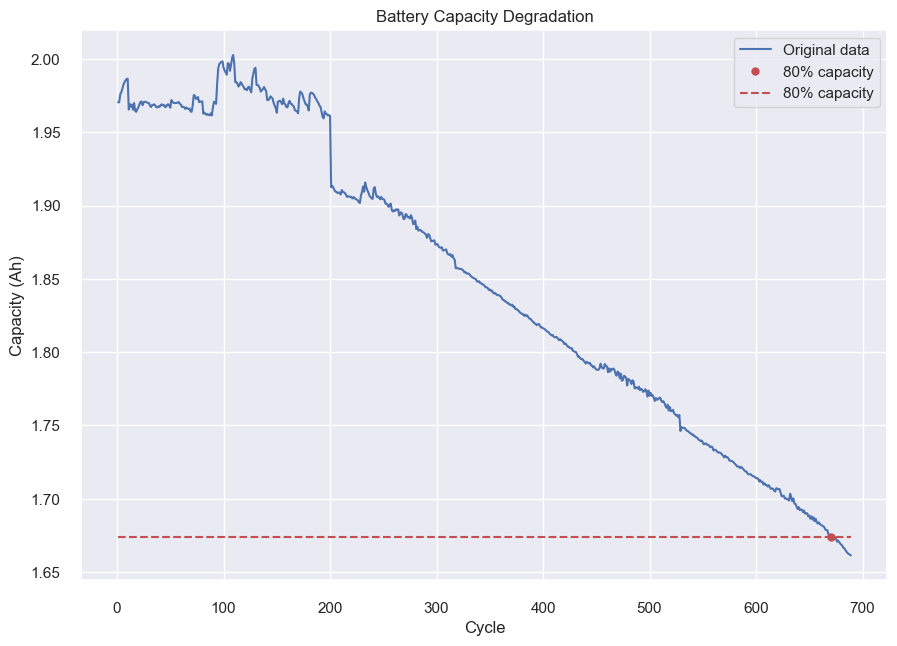

In [17]:
plot_raw(true_capacity5)

模型评估


In [21]:
import numpy as np
from numpy.polynomial.polynomial import Polynomial

def fit_partial(y, l, r, order):
    y = y[l:r]
    x = np.arange(l, r)
    coef = np.polyfit(x, y, order)
    poly = Polynomial(coef[::-1])
    return poly

def pred_80pct_cycle(poly, initial_capacity):
    coef = poly.coef
    beta_0, beta_1 = coef
    # print(f'intial capacity: {initial_capacity}')
    # print(f'β₀: {beta_0}, β₁: {beta_1}')
    # print(f'80% capacity cycle: {(THRESHOLD * initial_capacity - beta_0) / beta_1}')
    return (THRESHOLD * initial_capacity - beta_0) / beta_1, THRESHOLD * initial_capacity

In [22]:
def plot_poly_pred(poly, x, y, cycle_l, cycle_r):
    plt.figure(figsize=(8, 5))
    y_fit = poly(x)
    plt.plot(x, y, 'bo', label='Original data', markersize=2)
    plt.plot(x, y_fit, 'g-', label='Fitted Curve')
    plt.plot(*get_80pct_cycle(y), 'bo', label='80% Capacity')
    plt.plot(*pred_80pct_cycle(poly, y[0]), 'go', label='Predicted 80% Capacity')
    
    plt.plot([cycle_l, cycle_l], [y[cycle_l]-.1, y[cycle_l]+.1], 'g--', label='Window Range')
    plt.plot([cycle_r, cycle_r], [y[cycle_r]-.1, y[cycle_r]+.1], 'g--')
    
    plt.title('Battery Capacity Degradation', fontsize=18)
    plt.xlabel('Cycle', fontsize=16)
    plt.ylabel('Capacity (mAh)', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

In [32]:
def plot_iteration_withTrueCapacity(capacity):
    l = 400
    r = 500
    ORDER = 1
    delta_l = 20
    
    cycle = np.arange(1, len(capacity) + 1)
    while r < len(capacity):
        poly = fit_partial(capacity, l, r, ORDER)
        print(f'Partial fit with ({l}, {r})')
        cycle_true, capa_true = get_80pct_cycle(capacity)
        cycle_pred, capa_pred = pred_80pct_cycle(poly, capacity[0])
        print(f'80% capacity: true: {cycle_true}, pred: {cycle_pred:.2f}')
        print(f"error: {abs(cycle_true-cycle_pred):.2f} cycle, relative error: {abs(cycle_true-cycle_pred)/cycle_true:.2%}")
        plot_poly_pred(poly, cycle, capacity, l, r)
        l += delta_l
        r += delta_l

Partial fit with (400, 500)
80% capacity: true: 670, pred: 724.01
error: 54.01 cycle, relative error: 8.06%


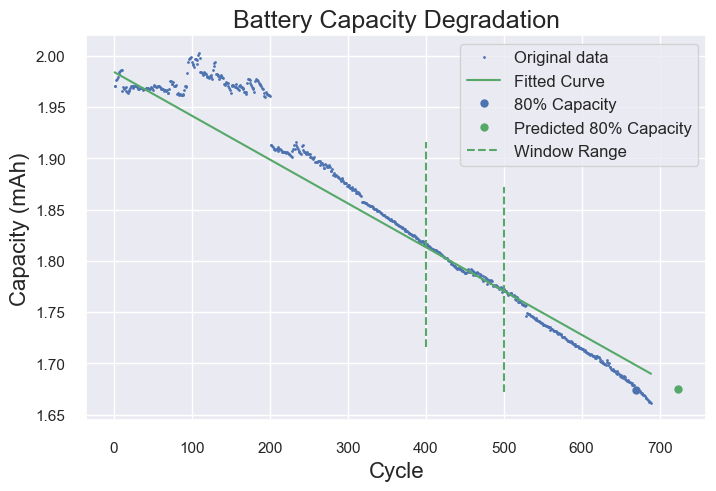

Partial fit with (420, 520)
80% capacity: true: 670, pred: 736.23
error: 66.23 cycle, relative error: 9.89%


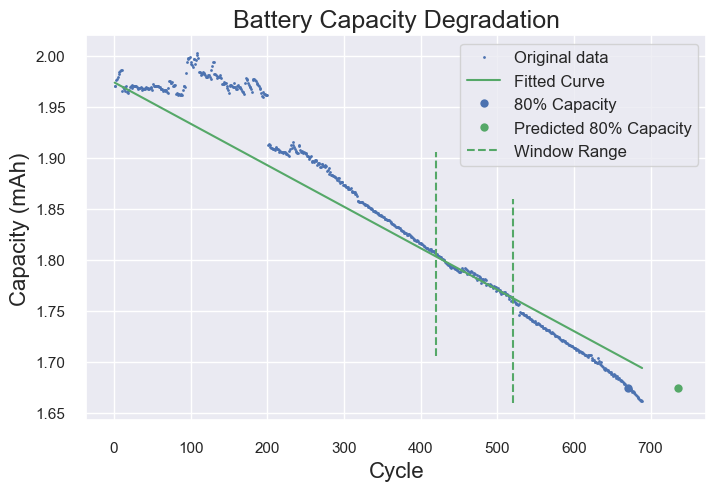

Partial fit with (440, 540)
80% capacity: true: 670, pred: 692.64
error: 22.64 cycle, relative error: 3.38%


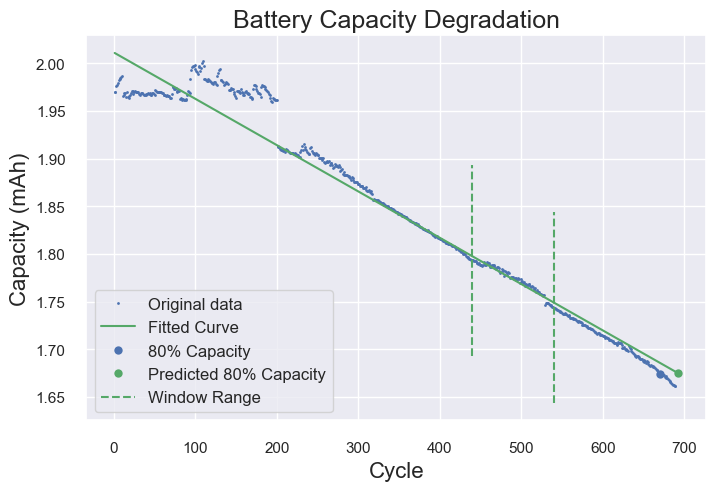

Partial fit with (460, 560)
80% capacity: true: 670, pred: 660.78
error: 9.22 cycle, relative error: 1.38%


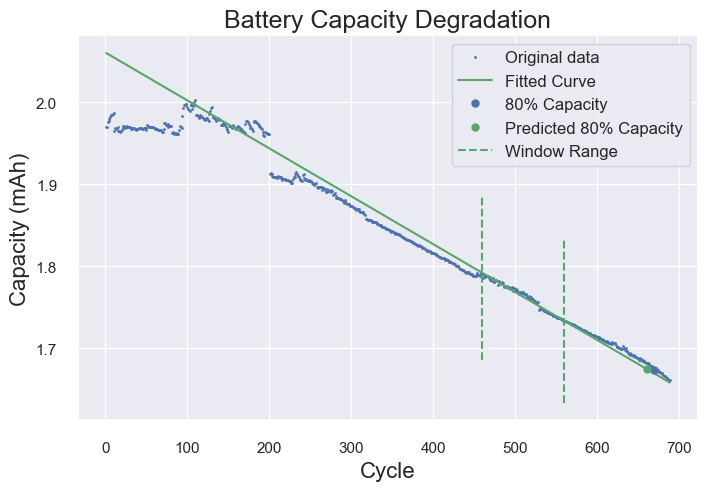

Partial fit with (480, 580)
80% capacity: true: 670, pred: 657.30
error: 12.70 cycle, relative error: 1.90%


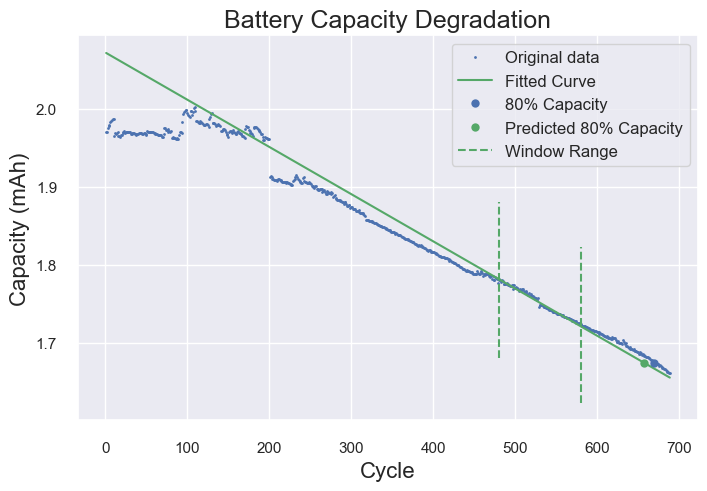

Partial fit with (500, 600)
80% capacity: true: 670, pred: 661.50
error: 8.50 cycle, relative error: 1.27%


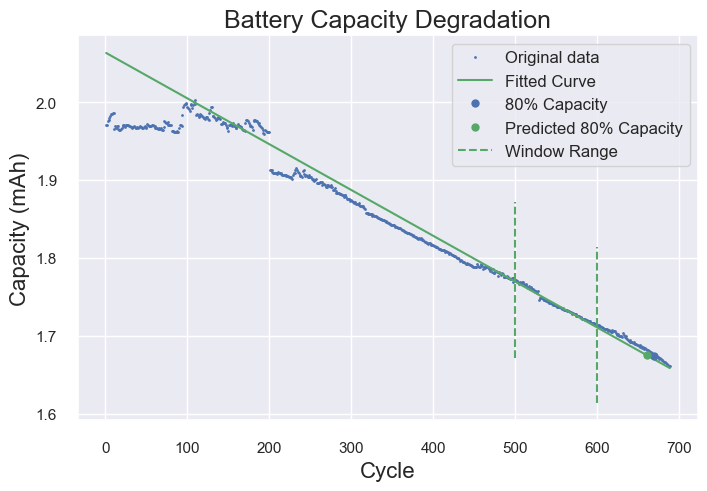

Partial fit with (520, 620)
80% capacity: true: 670, pred: 674.12
error: 4.12 cycle, relative error: 0.61%


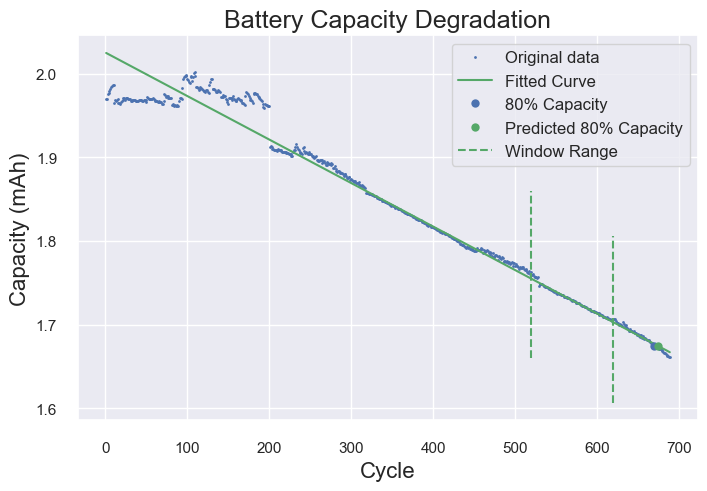

Partial fit with (540, 640)
80% capacity: true: 670, pred: 680.74
error: 10.74 cycle, relative error: 1.60%


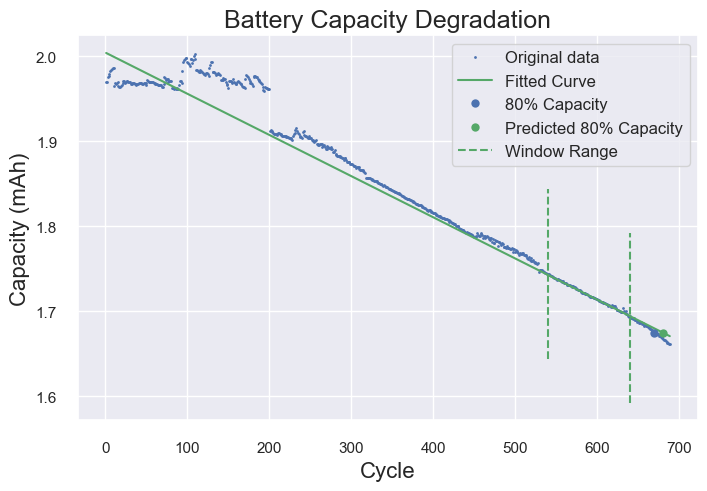

Partial fit with (560, 660)
80% capacity: true: 670, pred: 677.28
error: 7.28 cycle, relative error: 1.09%


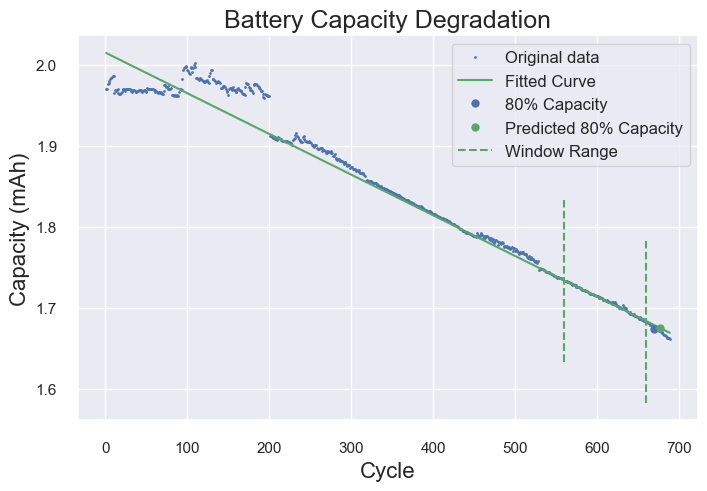

Partial fit with (580, 680)
80% capacity: true: 670, pred: 672.70
error: 2.70 cycle, relative error: 0.40%


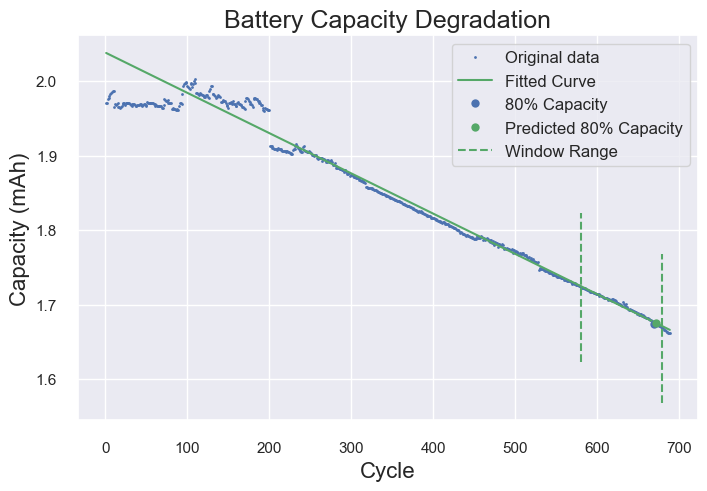

In [33]:
plot_iteration_withTrueCapacity(true_capacity5)

Partial fit with (400, 500)
80% capacity: true: 656, pred: 734.56
error: 78.56 cycle, relative error: 11.98%


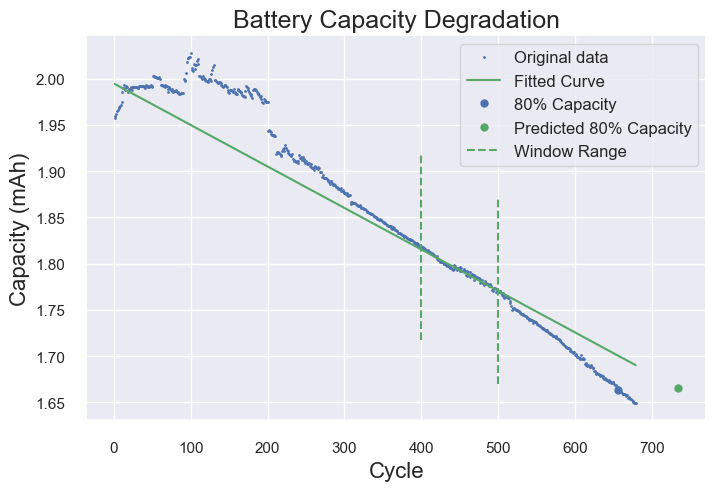

Partial fit with (420, 520)
80% capacity: true: 656, pred: 721.94
error: 65.94 cycle, relative error: 10.05%


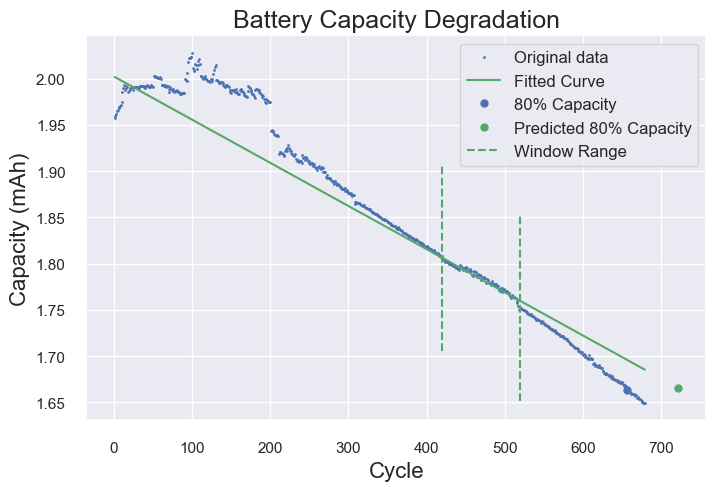

Partial fit with (440, 540)
80% capacity: true: 656, pred: 671.56
error: 15.56 cycle, relative error: 2.37%


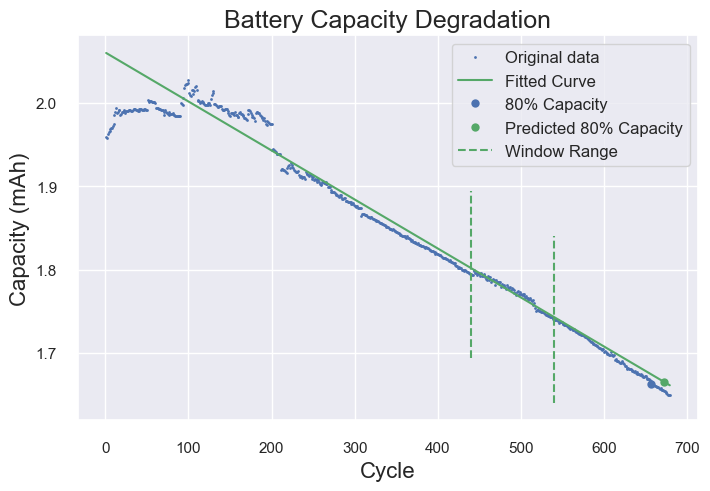

Partial fit with (460, 560)
80% capacity: true: 656, pred: 656.60
error: 0.60 cycle, relative error: 0.09%


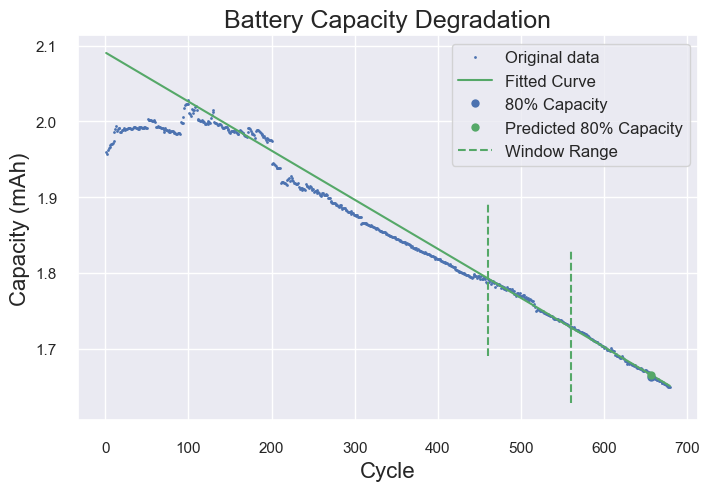

Partial fit with (480, 580)
80% capacity: true: 656, pred: 655.11
error: 0.89 cycle, relative error: 0.14%


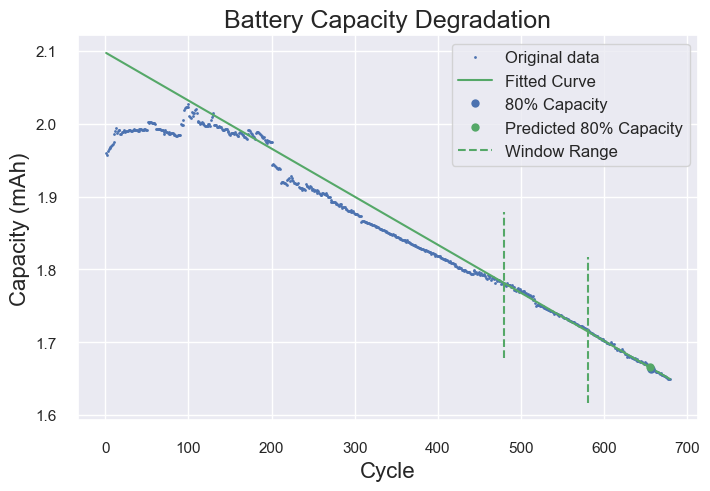

Partial fit with (500, 600)
80% capacity: true: 656, pred: 655.89
error: 0.11 cycle, relative error: 0.02%


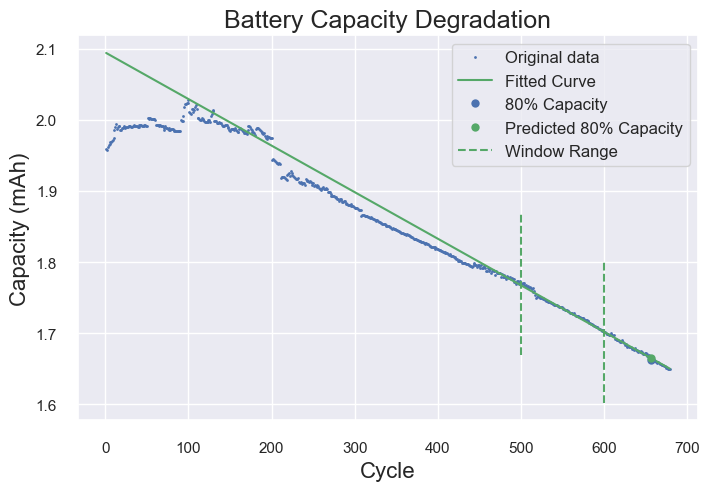

Partial fit with (520, 620)
80% capacity: true: 656, pred: 657.47
error: 1.47 cycle, relative error: 0.22%


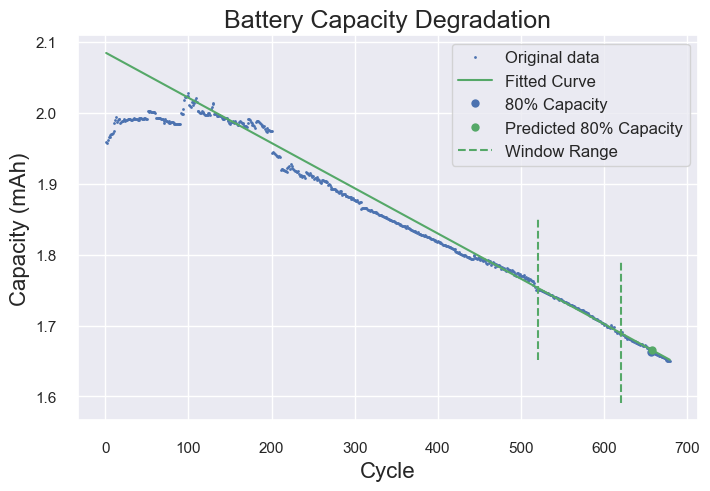

Partial fit with (540, 640)
80% capacity: true: 656, pred: 653.66
error: 2.34 cycle, relative error: 0.36%


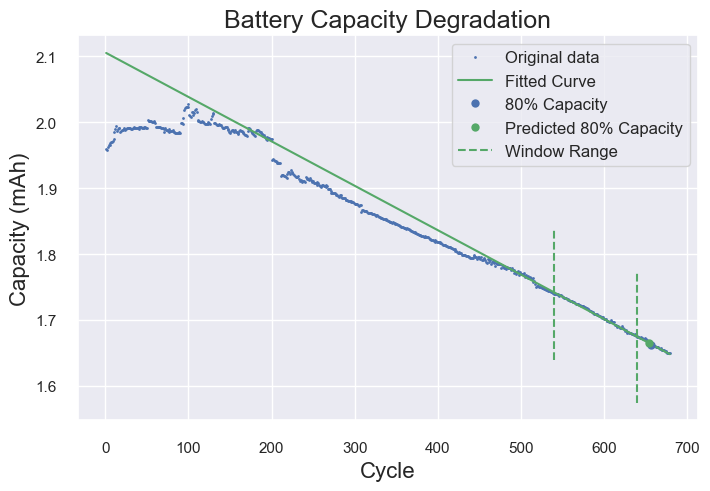

Partial fit with (560, 660)
80% capacity: true: 656, pred: 654.08
error: 1.92 cycle, relative error: 0.29%


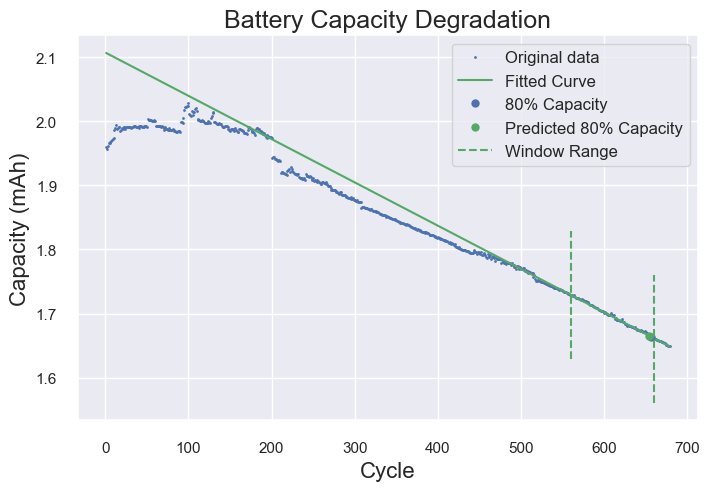

In [34]:
plot_iteration_withTrueCapacity(true_capacity4)

Partial fit with (400, 500)
80% capacity: true: 791, pred: 825.12
error: 34.12 cycle, relative error: 4.31%


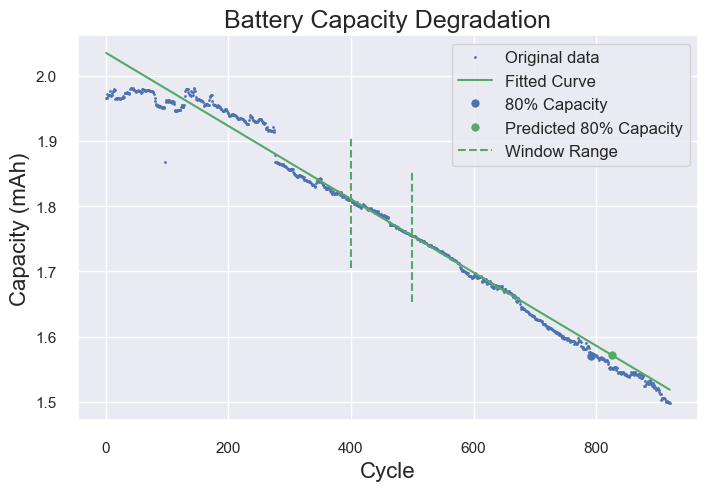

Partial fit with (420, 520)
80% capacity: true: 791, pred: 806.63
error: 15.63 cycle, relative error: 1.98%


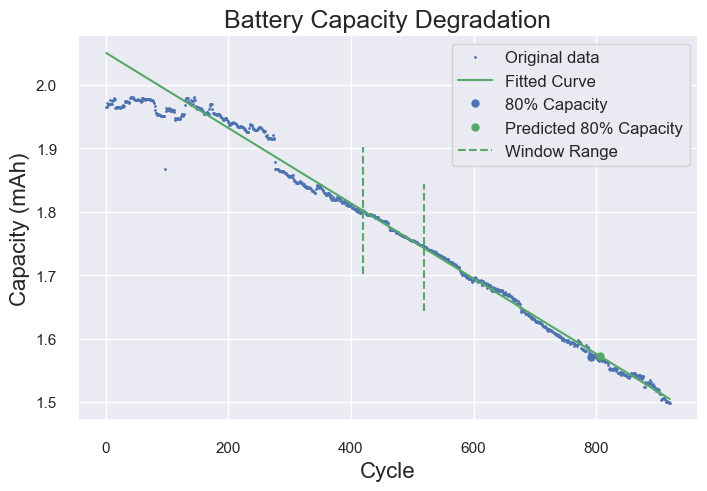

Partial fit with (440, 540)
80% capacity: true: 791, pred: 816.93
error: 25.93 cycle, relative error: 3.28%


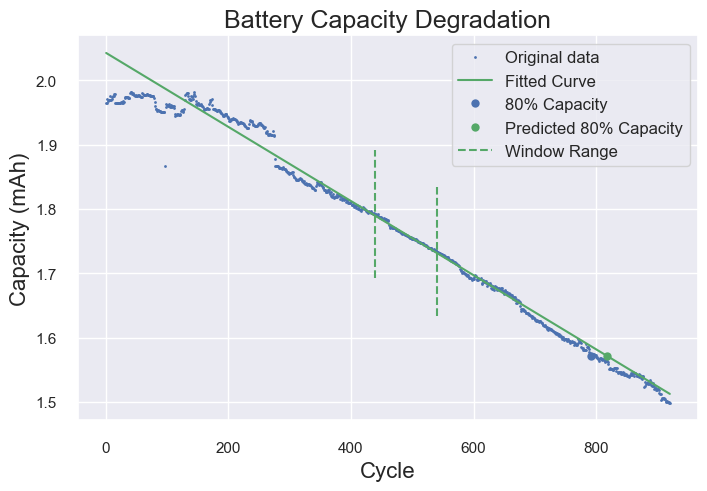

Partial fit with (460, 560)
80% capacity: true: 791, pred: 849.87
error: 58.87 cycle, relative error: 7.44%


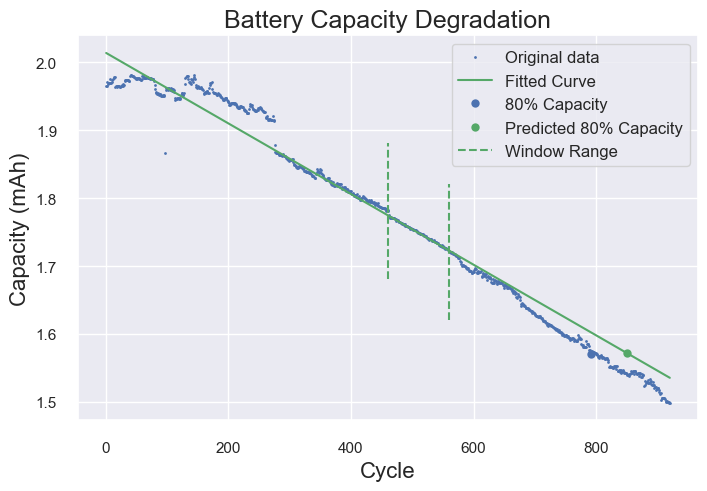

Partial fit with (480, 580)
80% capacity: true: 791, pred: 832.26
error: 41.26 cycle, relative error: 5.22%


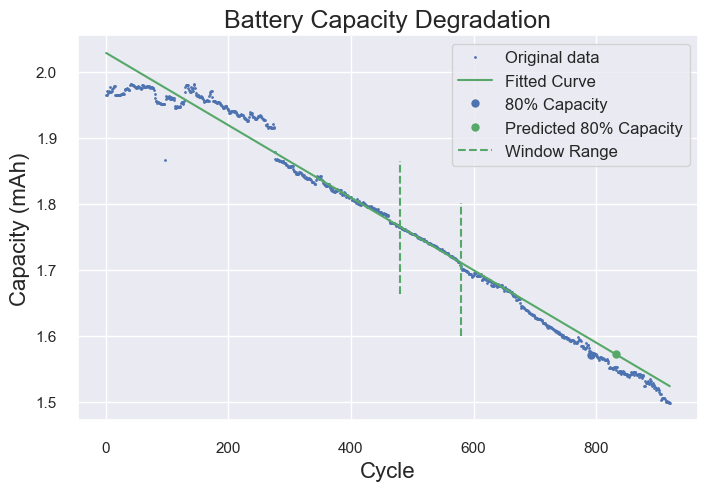

Partial fit with (500, 600)
80% capacity: true: 791, pred: 784.56
error: 6.44 cycle, relative error: 0.81%


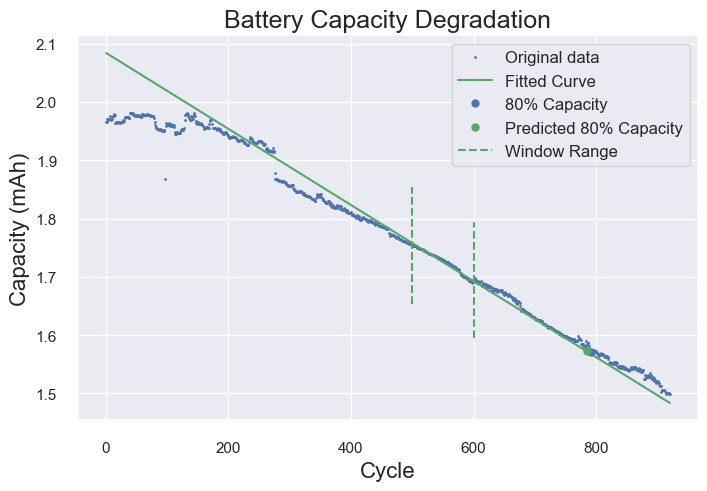

Partial fit with (520, 620)
80% capacity: true: 791, pred: 788.69
error: 2.31 cycle, relative error: 0.29%


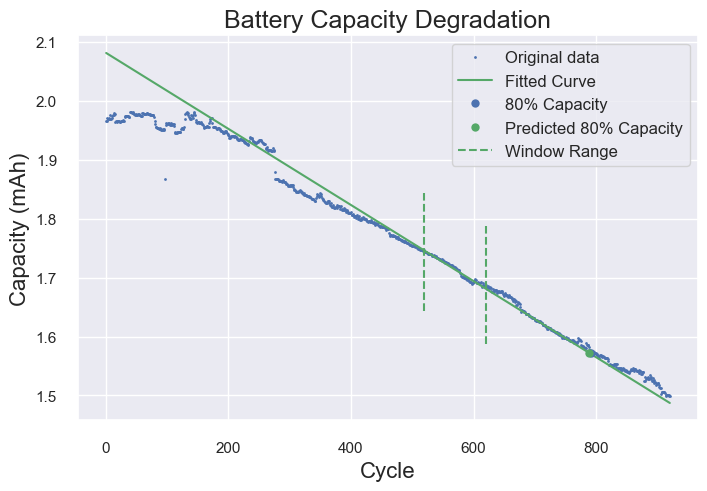

Partial fit with (540, 640)
80% capacity: true: 791, pred: 802.91
error: 11.91 cycle, relative error: 1.51%


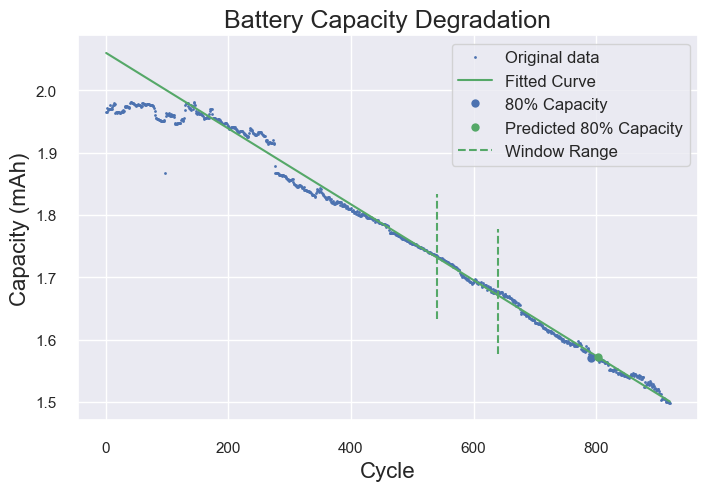

Partial fit with (560, 660)
80% capacity: true: 791, pred: 839.10
error: 48.10 cycle, relative error: 6.08%


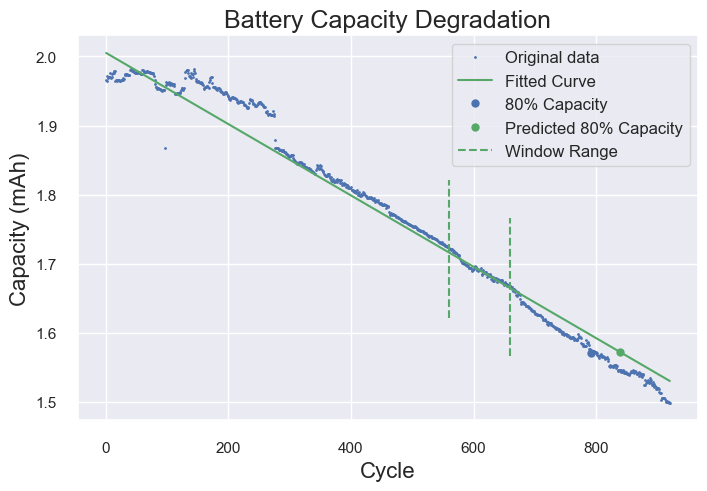

Partial fit with (580, 680)
80% capacity: true: 791, pred: 844.74
error: 53.74 cycle, relative error: 6.79%


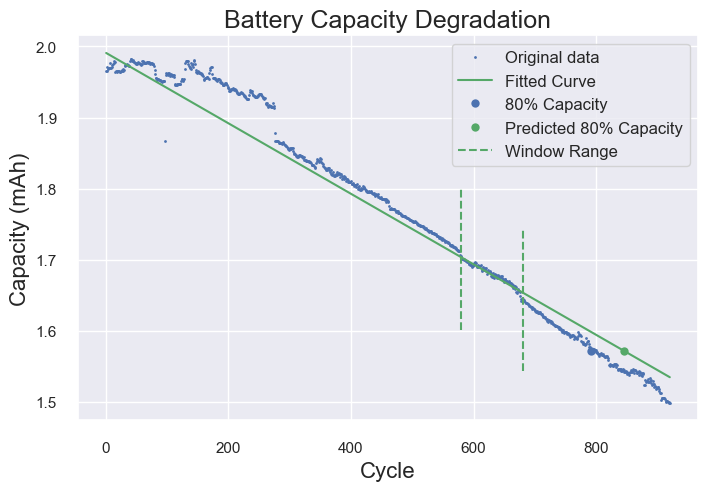

Partial fit with (600, 700)
80% capacity: true: 791, pred: 793.04
error: 2.04 cycle, relative error: 0.26%


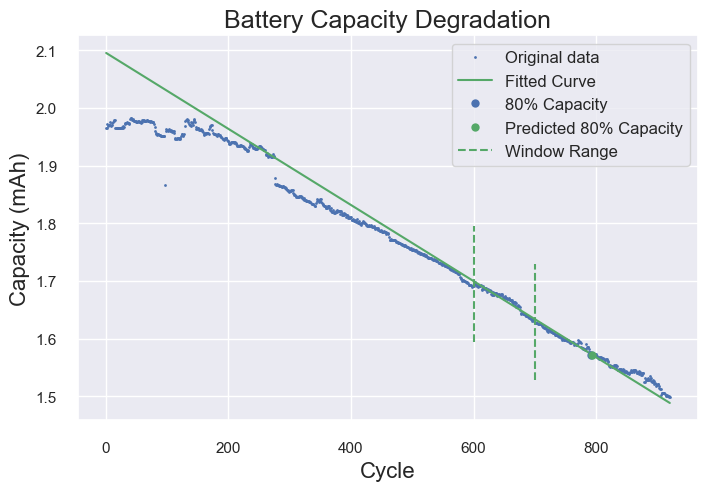

Partial fit with (620, 720)
80% capacity: true: 791, pred: 777.55
error: 13.45 cycle, relative error: 1.70%


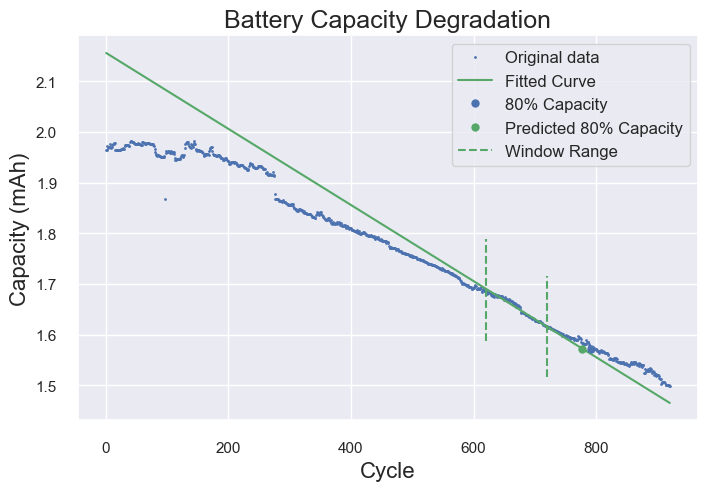

Partial fit with (640, 740)
80% capacity: true: 791, pred: 774.16
error: 16.84 cycle, relative error: 2.13%


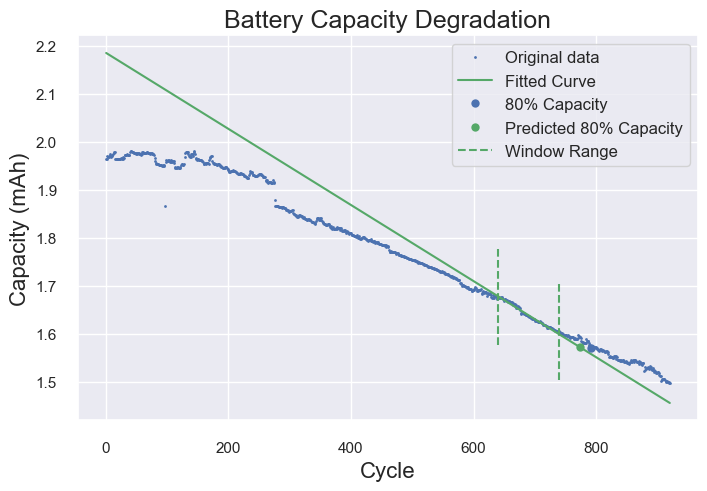

Partial fit with (660, 760)
80% capacity: true: 791, pred: 781.66
error: 9.34 cycle, relative error: 1.18%


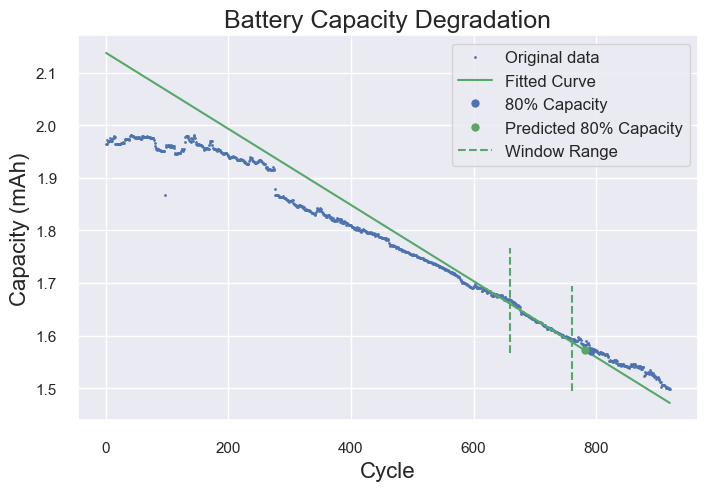

Partial fit with (680, 780)
80% capacity: true: 791, pred: 795.96
error: 4.96 cycle, relative error: 0.63%


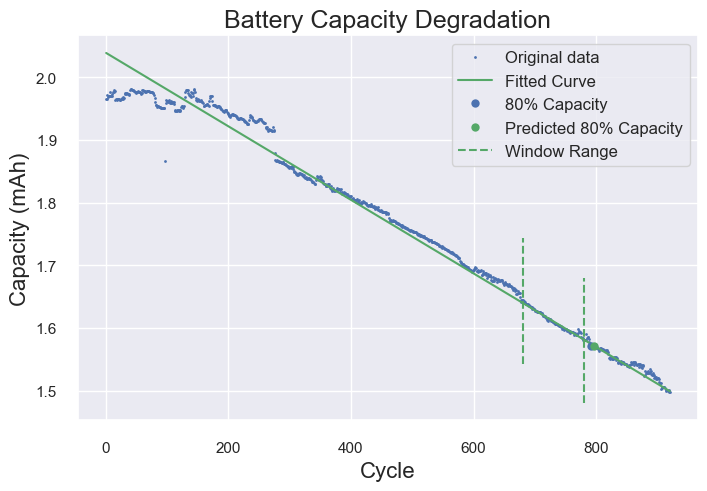

Partial fit with (700, 800)
80% capacity: true: 791, pred: 799.16
error: 8.16 cycle, relative error: 1.03%


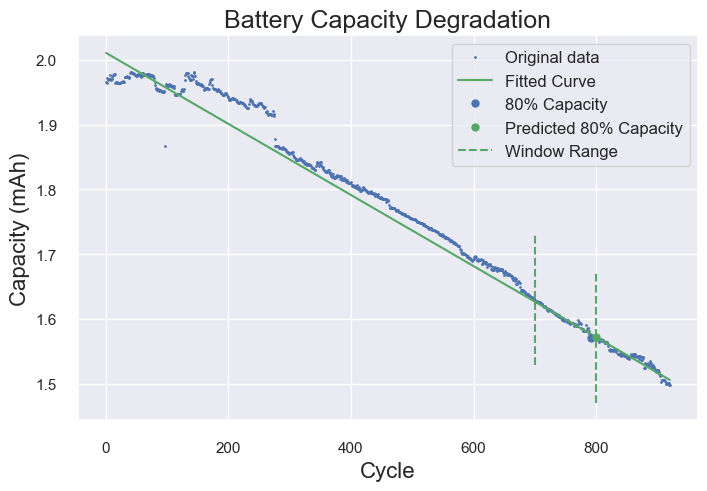

Partial fit with (720, 820)
80% capacity: true: 791, pred: 798.82
error: 7.82 cycle, relative error: 0.99%


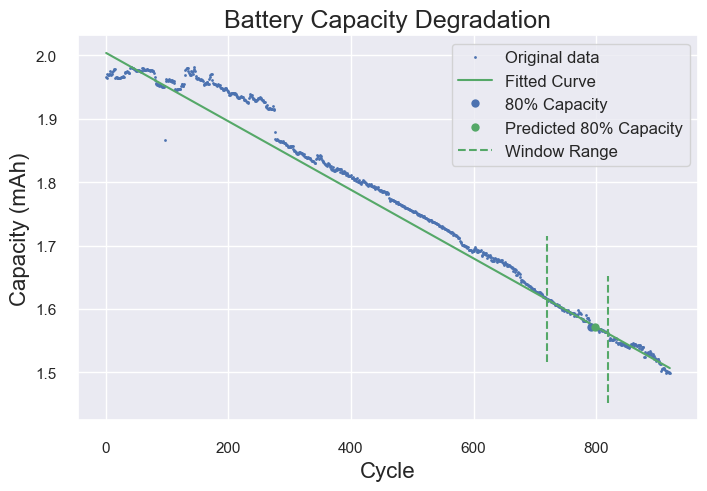

Partial fit with (740, 840)
80% capacity: true: 791, pred: 796.21
error: 5.21 cycle, relative error: 0.66%


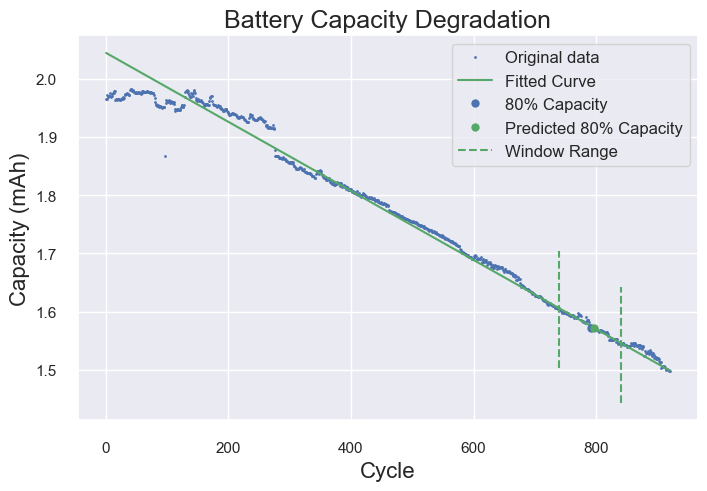

Partial fit with (760, 860)
80% capacity: true: 791, pred: 798.00
error: 7.00 cycle, relative error: 0.88%


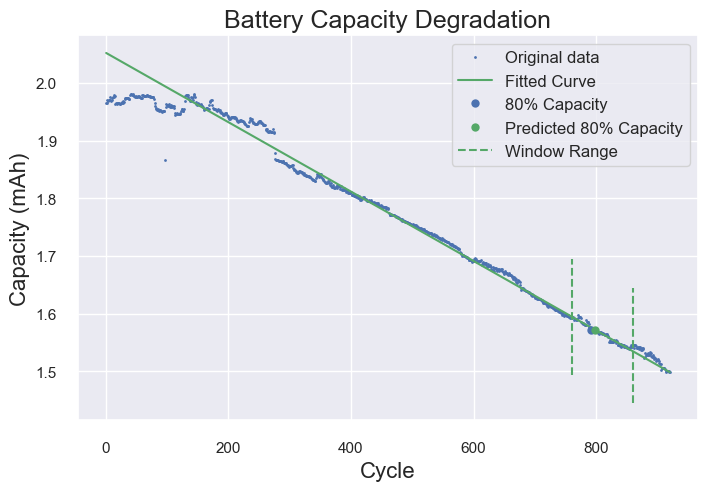

Partial fit with (780, 880)
80% capacity: true: 791, pred: 795.00
error: 4.00 cycle, relative error: 0.51%


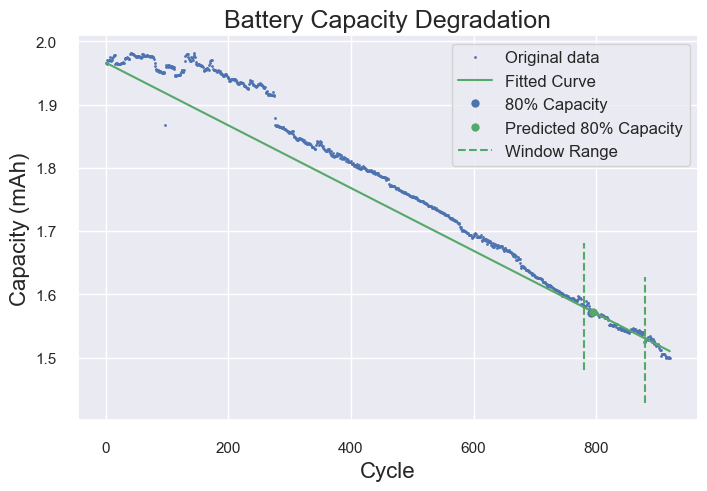

Partial fit with (800, 900)
80% capacity: true: 791, pred: 788.09
error: 2.91 cycle, relative error: 0.37%


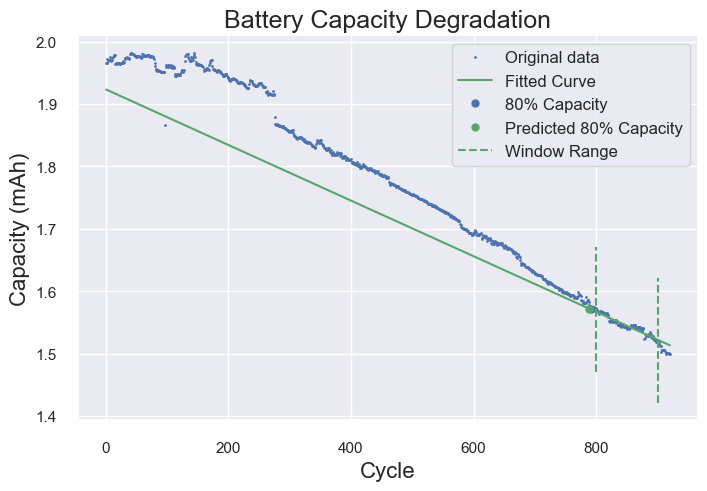

In [37]:
plot_iteration_withTrueCapacity(true_capacity6)

神经网络模型

In [ ]:
from keras.models import Sequential
from keras.layers import Dense

# 单特征输入
input_dim = 1

model_mlp = Sequential([
    Dense(64, input_dim=input_dim, activation='relu'),  # 第一隐藏层
    Dense(32, activation='relu'),  # 第二隐藏层
    Dense(1, activation='linear')  # 输出层，线性激活函数用于回归问题
])

model_mlp.compile(optimizer='adam', loss='mean_squared_error')


In [13]:
import torch
from torch import nn

class LSTMNet(nn.Module):
    def __init__(self):
        super(LSTMNet, self).__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=64, num_layers=1, batch_first=True)  # 假设输入特征只有1维
        self.fc = nn.Linear(64, 1)  # 假设我们做的是回归任务
    
    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (h_n, _) = self.lstm(x)
        x = h_n[-1, :, :]
        return self.fc(x)


In [38]:
from torch import optim

L = 0
R = 800

model = LSTMNet()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 假设你已经有了训练数据X_train和y_train
# 注意：在训练之前，你需要将数据转换为Tensor

X_train = torch.tensor(cycle[L:R]).float().unsqueeze(-1).unsqueeze(-1)  # 增加两个维度
# 现在X_train的形状应该是 [batch_size, seq_len, features]，其中seq_len=1, features=1
y_train = torch.tensor(capacity[L:R]).float().unsqueeze(-1)  # 确保y_train也有正确的维度


# 训练模型（示例）
for epoch in range(1000):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 1, Loss: 4.116542339324951
Epoch 101, Loss: 0.017852412536740303
Epoch 201, Loss: 0.0052198306657373905
Epoch 301, Loss: 0.0022059394977986813
Epoch 401, Loss: 0.0011494491482153535
Epoch 501, Loss: 0.000687076011672616
Epoch 601, Loss: 0.00045963324373587966
Epoch 701, Loss: 0.0003594931913539767
Epoch 801, Loss: 0.00027285516262054443
Epoch 901, Loss: 0.00024052165099419653


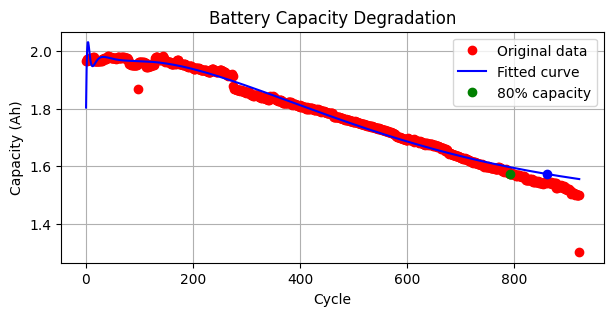

80% capacity cycle: 861, true: 791, diff: 70


In [39]:
y_pred = model(torch.tensor(cycle).float().unsqueeze(-1).unsqueeze(-1)).detach().numpy().flatten()
plt.figure(figsize=(7, 3))
plt.plot(cycle, capacity, 'ro', label='Original data')
plt.plot(cycle, y_pred, 'b-', label='Fitted curve')
plt.plot(*get_80pct_cycle(capacity), 'go', label='80% capacity')
for y in y_pred:
    if y < 0.8 * capacity[0]:
        plt.plot(cycle[y_pred == y], y_pred[y_pred == y], 'bo')
        target_cycle = cycle[y_pred == y][0]
        break
# plt.plot(*pred_80pct_cycle(poly, y[0]), 'bo', label='Predicted 80% capacity')
plt.title('Battery Capacity Degradation')
plt.xlabel('Cycle')
plt.ylabel('Capacity (Ah)')
plt.legend()
plt.grid(True)
plt.show()

print(f'80% capacity cycle: {target_cycle}, true: {get_80pct_cycle(capacity)[0]}, diff: {abs(target_cycle-get_80pct_cycle(capacity)[0])}')